In [33]:
import fastai; fastai.__version__
from fastai.vision import *
import sys; sys.path.append("../dev")

In [34]:
PATH = Path("/home/turgutluk/data/breast_path/")

In [35]:
EXPORT_PATH = Path("/home/turgutluk/git/fast-kaggle/breast_path/experiment_exports/")

In [36]:
EXPORT_PATH.ls()

[PosixPath('/home/turgutluk/git/fast-kaggle/breast_path/experiment_exports/experiment3'),
 PosixPath('/home/turgutluk/git/fast-kaggle/breast_path/experiment_exports/experiment_dummy'),
 PosixPath('/home/turgutluk/git/fast-kaggle/breast_path/experiment_exports/experiment2'),
 PosixPath('/home/turgutluk/git/fast-kaggle/breast_path/experiment_exports/experiment1'),
 PosixPath('/home/turgutluk/git/fast-kaggle/breast_path/experiment_exports/experiment4')]

In [37]:
EXPERIMENT = EXPORT_PATH/'experiment_dummy'

In [38]:
EXPERIMENT.ls()

[PosixPath('/home/turgutluk/git/fast-kaggle/breast_path/experiment_exports/experiment_dummy/training_log.csv'),
 PosixPath('/home/turgutluk/git/fast-kaggle/breast_path/experiment_exports/experiment_dummy/Test_raw_preds.pkl'),
 PosixPath('/home/turgutluk/git/fast-kaggle/breast_path/experiment_exports/experiment_dummy/Valid_raw_preds.pkl'),
 PosixPath('/home/turgutluk/git/fast-kaggle/breast_path/experiment_exports/experiment_dummy/cli_log.json'),
 PosixPath('/home/turgutluk/git/fast-kaggle/breast_path/experiment_exports/experiment_dummy/models')]

### logs

In [39]:
training_log = pd.read_csv(EXPERIMENT/'training_log.csv')

In [40]:
training_log.tail()

epoch train_loss valid_loss      dice   time
28     5   0.170112   0.182917  0.919701  00:07
29     6   0.167248   0.187749  0.919510  00:10
30     7   0.166271   0.192246  0.912876  00:07
31     8   0.162128   0.201801  0.912939  00:07
32     9   0.161380   0.196691  0.915981  00:06

### cli logs

In [43]:
import json
log = json.loads(open(EXPERIMENT/'cli_log.json').read())[-1]

In [44]:
log.keys()

dict_keys(['start_time', 'end_time', 'command', 'stderr', 'stdout'])

In [45]:
start_time, end_time, command, stderr, stdout = log.values()

In [46]:
start_time, end_time

('10/13/2019, 17:08:49', '10/13/2019, 17:12:52')

In [47]:
command

['python',
 '/home/turgutluk/git/fast-kaggle/dev/segmentation_training.py',
 '--PATH=/home/turgutluk/data/breast_path',
 '--IMAGES=images',
 '--MASKS=labels',
 '--CODES=codes.txt',
 '--TRAIN=train.txt',
 '--VALID=0.1',
 '--TEST=test.txt',
 '--suffix=.tif',
 '--bs=8',
 '--size=320',
 '--max_lr=0.001',
 '--modelname=resdunet18',
 '--modelconfig={}',
 '--epochs=10',
 '--tracking_metric=dice',
 '--loss_function=cross_entropy',
 '--max_lr=0.001',
 '--epochs=10',
 '--opt=adamw',
 '--EXPORT_PATH=experiment_exports/experiment_dummy']

### models

In [48]:
(EXPERIMENT/'models').ls()

[PosixPath('/home/turgutluk/git/fast-kaggle/breast_path/experiment_exports/experiment_dummy/models/best_of_resdunet18.pth')]

### valid preds (optional post process)

In [49]:
from local.segmentation.dataset import SemanticSegmentationData as ssdata

In [50]:
valid_preds = torch.load(EXPERIMENT/'Valid_raw_preds.pkl')

In [51]:
valid_preds.keys()

dict_keys(['fnames', 'preds', 'targs'])

In [52]:
fnames = valid_preds['fnames']
valpreds = valid_preds['preds']
valtargs = valid_preds['targs']

In [53]:
# get original labels
original_labels = [open_mask(ssdata.get_y_fn(PATH/'labels', '.tif', o)) for o in fnames]

In [54]:
# get original images
original_images = [open_image(o) for o in fnames]

In [55]:
# argmax preds 
argmax_preds = valpreds.argmax(1).unsqueeze(1); argmax_preds.shape

torch.Size([4, 1, 320, 320])

In [56]:
valtargs[0].shape

torch.Size([1, 320, 320])

In [57]:
argmax_preds[0].shape

torch.Size([1, 320, 320])

In [58]:
def _plot_val(n):
    "plot"
    fig, axes = plt.subplots(n,4, figsize=(4*10,n*10))
    for i, ax in zip(range(n), axes):
        # original image
        original_images[i].show(figsize=(5,5), ax=ax[0]); ax[0].set_title("SHG")
        # original label
        original_labels[i].show(figsize=(5,5), ax=ax[1], cmap='gray', alpha=1.); ax[1].set_title("Original Label")
        # resized label - downscaled to (320,320)
        ImageSegment(valtargs[i]).show(figsize=(5,5), ax=ax[2], cmap='gray', alpha=1.); ax[2].set_title("Downscaled Label (320,320)")
        # argmax pred
        ImageSegment(argmax_preds[i]).show(figsize=(5,5), ax=ax[3], cmap='gray', alpha=1.); ax[3].set_title("Argmax Pred");
    return fig

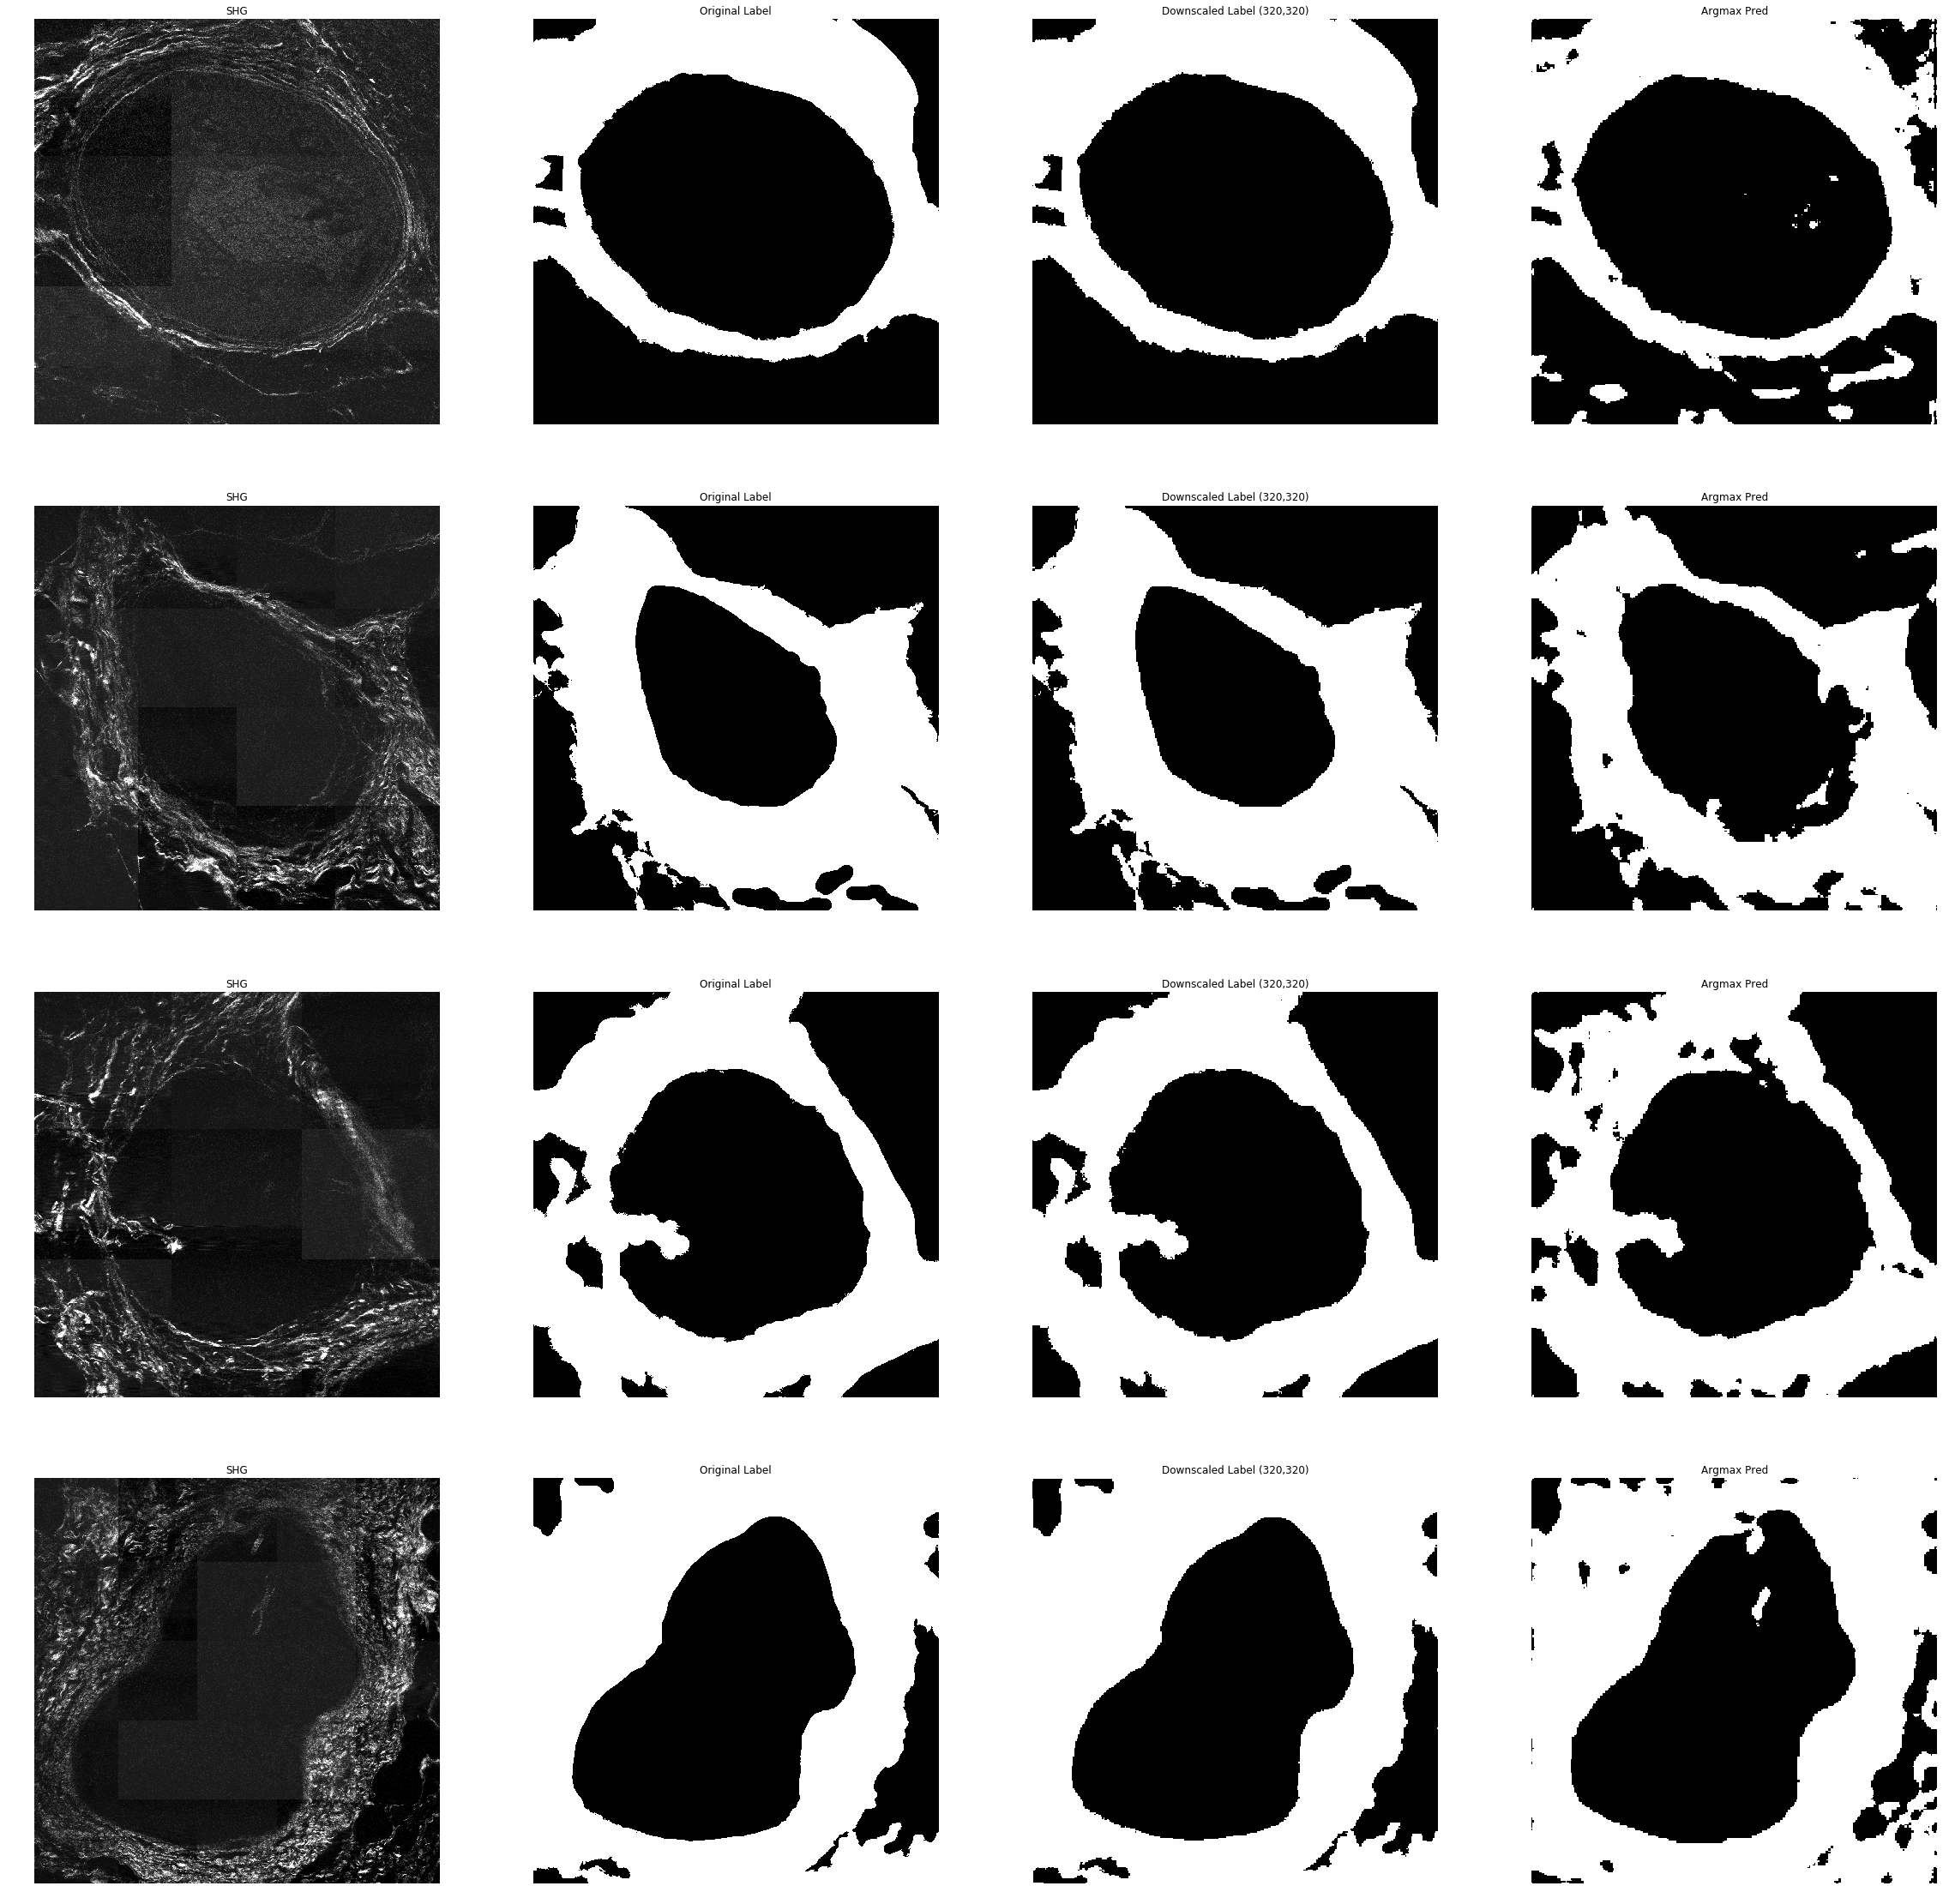

In [59]:
fig = _plot_val(len(fnames))

In [60]:
# IMGPATH = EXPERIMENT/"valid_results.png"
# fig.savefig(IMGPATH)

# from IPython.display import FileLink
# FileLink(IMGPATH)

### test results - final evaluation

In [61]:
from local.segmentation.metrics import *

In [62]:
test_preds = torch.load(EXPERIMENT/'Test_raw_preds.pkl')

In [63]:
test_preds.keys()

dict_keys(['fnames', 'preds', 'targs'])

In [64]:
fnames = test_preds['fnames']
valpreds = test_preds['preds']
valtargs = test_preds['targs']

In [65]:
# get original labels
original_labels = [open_mask(ssdata.get_y_fn(PATH/'labels', '.tif', o)) for o in fnames]

In [66]:
# get original images
original_images = [open_image(o) for o in fnames]

In [67]:
# argmax preds 
argmax_preds = valpreds.argmax(1).unsqueeze(1); argmax_preds.shape

torch.Size([15, 1, 320, 320])

In [68]:
original_labels

[ImageSegment (1, 1148, 1517),
 ImageSegment (1, 1148, 1148),
 ImageSegment (1, 1886, 1886),
 ImageSegment (1, 1886, 1148),
 ImageSegment (1, 1886, 2255),
 ImageSegment (1, 2624, 2255),
 ImageSegment (1, 2624, 2624),
 ImageSegment (1, 1148, 1148),
 ImageSegment (1, 2624, 2255),
 ImageSegment (1, 1148, 779),
 ImageSegment (1, 2255, 1517),
 ImageSegment (1, 1148, 1148),
 ImageSegment (1, 779, 1148),
 ImageSegment (1, 2255, 2624),
 ImageSegment (1, 1517, 779)]

In [69]:
upsampled_argmax_preds = []
for o, t in zip(original_labels, argmax_preds):
    _new = F.interpolate(t[None,...].float(), size=o.size, mode='nearest')[0]
    _new = ImageSegment(_new)
    assert _new.size == o.size
    upsampled_argmax_preds.append(_new)

In [70]:
original_labels, upsampled_argmax_preds

([ImageSegment (1, 1148, 1517),
  ImageSegment (1, 1148, 1148),
  ImageSegment (1, 1886, 1886),
  ImageSegment (1, 1886, 1148),
  ImageSegment (1, 1886, 2255),
  ImageSegment (1, 2624, 2255),
  ImageSegment (1, 2624, 2624),
  ImageSegment (1, 1148, 1148),
  ImageSegment (1, 2624, 2255),
  ImageSegment (1, 1148, 779),
  ImageSegment (1, 2255, 1517),
  ImageSegment (1, 1148, 1148),
  ImageSegment (1, 779, 1148),
  ImageSegment (1, 2255, 2624),
  ImageSegment (1, 1517, 779)],
 [ImageSegment (1, 1148, 1517),
  ImageSegment (1, 1148, 1148),
  ImageSegment (1, 1886, 1886),
  ImageSegment (1, 1886, 1148),
  ImageSegment (1, 1886, 2255),
  ImageSegment (1, 2624, 2255),
  ImageSegment (1, 2624, 2624),
  ImageSegment (1, 1148, 1148),
  ImageSegment (1, 2624, 2255),
  ImageSegment (1, 1148, 779),
  ImageSegment (1, 2255, 1517),
  ImageSegment (1, 1148, 1148),
  ImageSegment (1, 779, 1148),
  ImageSegment (1, 2255, 2624),
  ImageSegment (1, 1517, 779)])

In [73]:
from local.segmentation.metrics import _dicee

In [76]:
dice_scores = [_dice(original_labels[i].data, upsampled_argmax_preds[i].data) for i in range(len(fnames))]
dice_scores, torch.mean(tensor(dice_scores))

([tensor(0.8905),
  tensor(0.9384),
  tensor(0.9450),
  tensor(0.9543),
  tensor(0.8615),
  tensor(0.9771),
  tensor(0.9401),
  tensor(0.9311),
  tensor(0.8867),
  tensor(0.9282),
  tensor(0.9355),
  tensor(0.9379),
  tensor(0.9317),
  tensor(0.8952),
  tensor(0.9235)],
 tensor(0.9251))

In [77]:
def _plot_test(n):
    "plot"
    fig, axes = plt.subplots(n,3, figsize=(3*10,n*10))
    for i, ax in zip(range(n), axes):
        # original image
        original_images[i].show(figsize=(5,5), ax=ax[0]); ax[0].set_title("SHG")
        # original label
        original_labels[i].show(figsize=(5,5), ax=ax[1], cmap='gray', alpha=1.); ax[1].set_title("Original Label")
        # final pred
        upsampled_argmax_preds[i].show(figsize=(5,5), ax=ax[2], cmap='gray', alpha=1.); ax[2].set_title("Final Pred")
    return fig

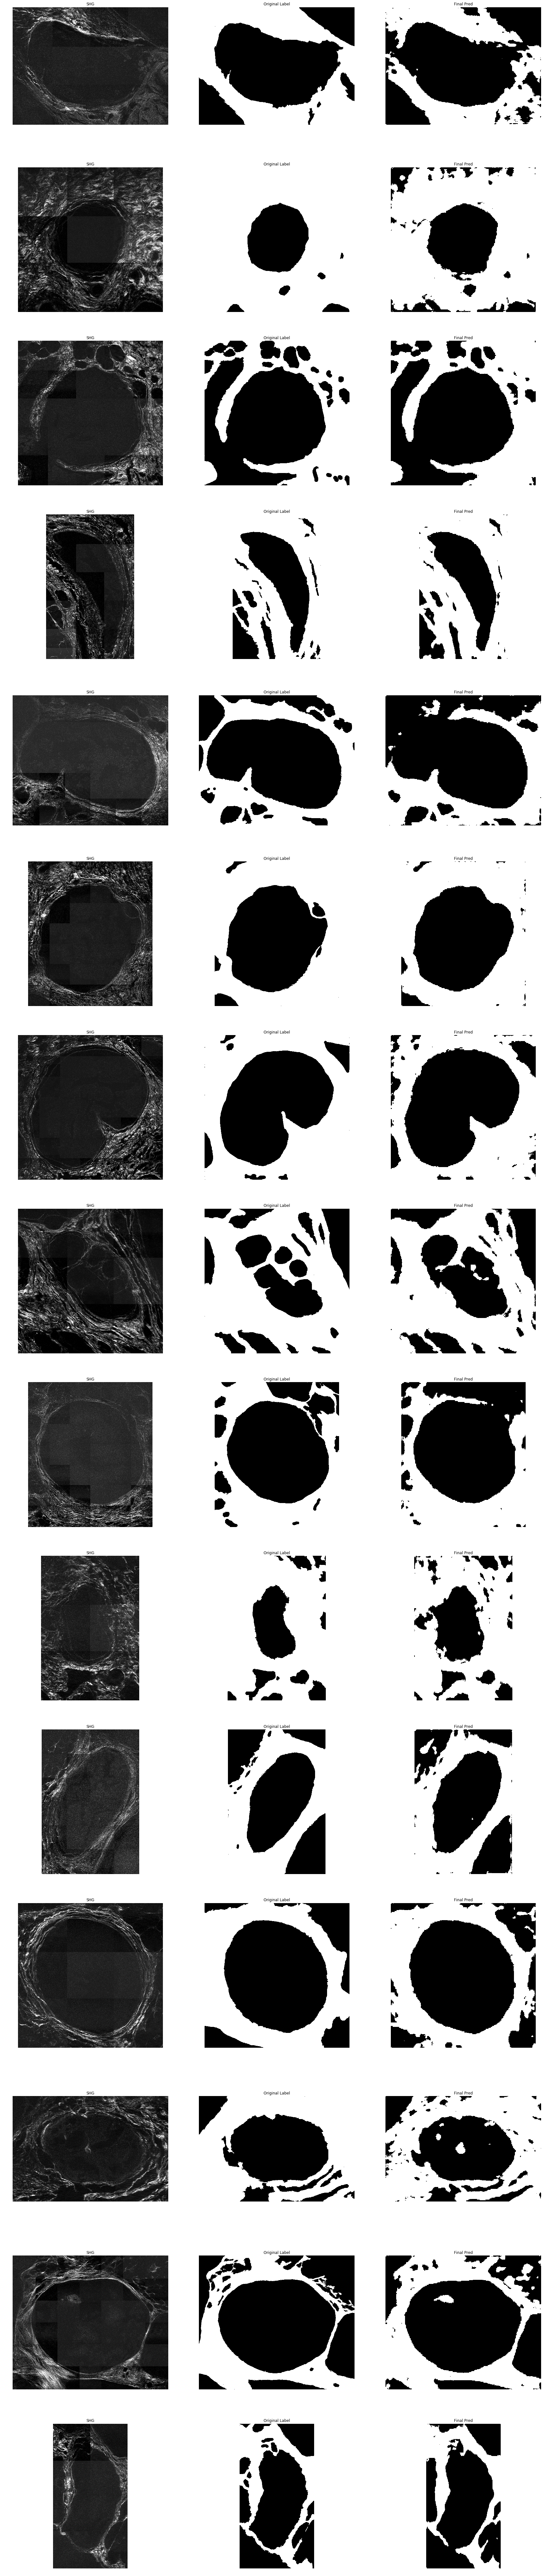

In [78]:
fig = _plot_test(len(fnames))

In [79]:
# IMGPATH = EXPERIMENT/"test_results.png"
# fig.savefig(IMGPATH)

### fin